# README

In [34]:
%matplotlib inline
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import NMF 

## Draw court

Function to draw the basketball court

In [35]:
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 46cm so it has a radius of 23cm, which is a value
    # 2.3 in our coordinate system
    hoop = Circle((0, 0), radius=2.3, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-9, -2.3), 18, -0.1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=4.9m, height=5.8m
    outer_box = Rectangle((-24.45, -14.3), 49, 58, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=3.6ft, height=5.8ft
    inner_box = Rectangle((-18, -14.3), 36, 58, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 43.7), 36, 36, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 43.7), 36, 36, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 25, 25, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 2.68m long before they begin to arc
    corner_three_a = Rectangle((-66, -14.3), 0, 28.8, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((66, -14.3), 0, 28.8, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 6.75m away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 135, 135, theta1=12, theta2=168, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 125.7), 36, 36, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 125.7), 12, 12, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [
        hoop,
        backboard,
        outer_box,
        inner_box,
        top_free_throw,
        bottom_free_throw,
        restricted,
        corner_three_a,
        corner_three_b,
        three_arc,
        center_outer_arc,
        center_inner_arc
    ]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-75, -14.3), 150, 140, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

## Transform data as a Pandas DataFrame

Get the data from the CSV and transform it into a Pandas DataFrame

In [36]:
currdir = os.getcwd()

datadir = os.path.abspath(os.path.join(currdir, '../../../data/uaap-season81-fibalivestats-shotchart-data-CLEANED.csv'))

fg_df = pd.read_csv(datadir)

## Load FG DataFrame

In [37]:
fg_df

,team,opponent,made,x,y,num,player,points,shot_type,date,venue
0,NU,UST,0,8,3,9,J. Clemente,2,jump shot,2018.09.08,MOA
1,NU,UST,1,0,2,10,I. Gaye,2,dunk,2018.09.08,MOA
2,NU,UST,1,-1,16,8,A. Joson,2,jump shot,2018.09.08,MOA
3,NU,UST,0,4,8,1,D. Ildefonso,2,jump shot,2018.09.08,MOA
4,NU,UST,0,62,43,1,D. Ildefonso,3,jump shot,2018.09.08,MOA
...,...,...,...,...,...,...,...,...,...,...,...
7614,ADU,FEU,1,-1,6,20,K. Bernardo,2,lay up,2018.11.18,MOA
7615,ADU,FEU,1,-7,-1,28,M. Macion,2,jump shot,2018.11.18,MOA
7616,ADU,FEU,0,8,6,9,W. Magbuhos,2,jump shot,2018.11.18,MOA
7617,ADU,FEU,0,4,0,17,J. Colonia,2,jump shot,2018.11.18,MOA


In [ ]:
fg_df['player'].nunique()

## Show shot chart of shooter

In [38]:
def show_shot_chart(shooter, title="shot chart"):

    plt.figure(figsize=(12,11))
    plt.scatter(shooter.x, shooter.y, c='green', s=3)

    draw_court(outer_lines=True)

    plt.xlim(-80,80)
    plt.ylim(-20, 140)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().set_facecolor('#ffffff')
    plt.gca().set_title(title)

    plt.show()

### Example (shot chart)

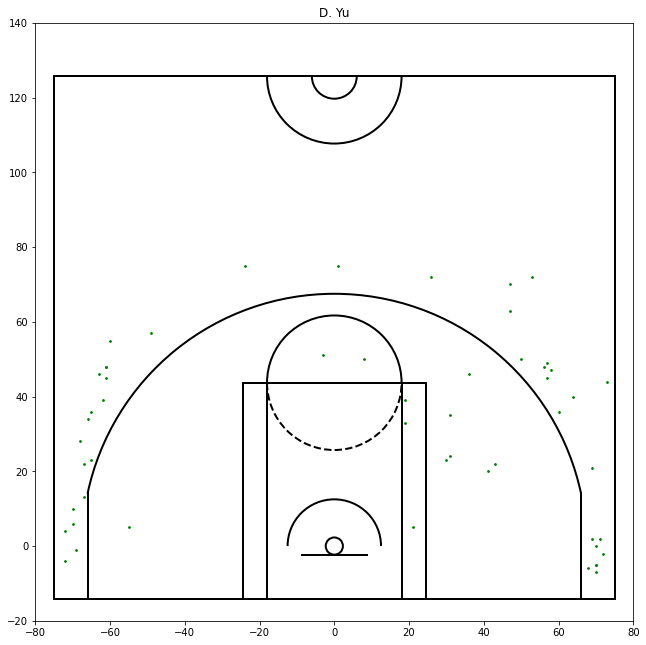

In [136]:
p = 'D. Yu'
shooter = fg_df[fg_df.player==p]
# shooter[shooter.points==3]
show_shot_chart(shooter, title=p)

## Generate court grid

In [39]:
def generate_xy_grids(xrange, yrange):
    x = np.arange(xrange[0], xrange[1], xrange[2])
    y = np.arange(yrange[0], yrange[1], yrange[2])

    return np.meshgrid(x, y)

## Get locations from dataframe for KDE

In [40]:
def get_locations(df):
    # each row of the array represents the x,y location of the FG (FG x 2 array)
    return np.vstack([df.x, df.y]).T

## Get kernel density estimates of court cells based a set of FG

In [41]:
def get_kde_court(locs, xy, **kde_options):
    kde = KernelDensity(bandwidth=kde_options['bandwidth'], kernel=kde_options['kernel']).fit(locs)    
    return np.exp(kde.score_samples(xy))

### Get set of players with total FG > 28

In [42]:
values = fg_df['player'].value_counts().values
pidx = np.where(values <= 27)[0][0]
players = fg_df['player'].value_counts().index[:pidx]

### Get KDE of players

In [97]:
# samples = []

# xgrid, ygrid = generate_xy_grids((-75,76,5), (-15,126,5))
# xy = np.vstack([xgrid.ravel(), ygrid.ravel()]).T

# for i in range(players.shape[0]):
#     shooter = fg_df[(fg_df.player==players[i]) & (fg_df.made<=1)]
#     if shooter.shape[0] > 14:
#         locs =  get_locations(shooter)
#         z = get_kde_court(locs, xy, bandwidth=5, kernel='gaussian')
#         samples.append(z)
#     else:
#         pass

# shots = np.vstack(samples)
# np.savetxt('fg_kde.csv', shots, delimiter=',')
# np.save('fg_kde.npy', shots)

### Example (KDE)

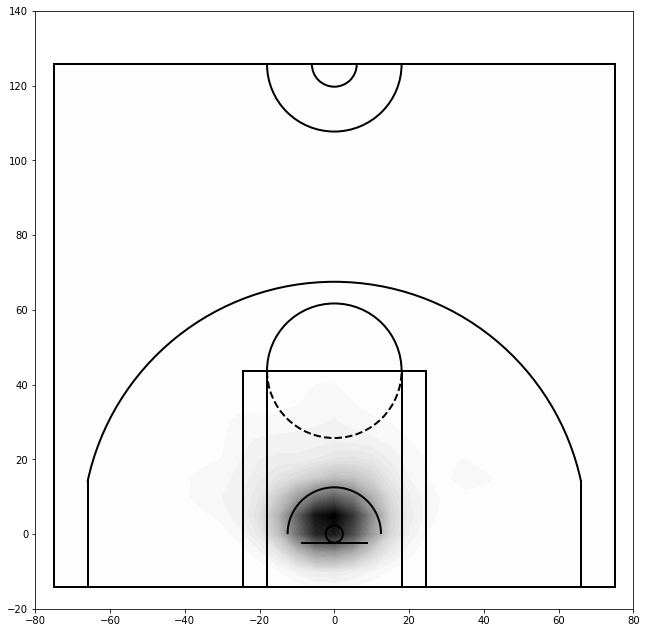

In [123]:
shooter = fg_df[fg_df.player=='B. Akhuetie']
locs =  get_locations(shooter)
xgrid, ygrid = generate_xy_grids((-75,76,5), (-15,126,5))
xy = np.vstack([xgrid.ravel(), ygrid.ravel()]).T
z = get_kde_court(locs, xy, bandwidth=5.0, kernel='gaussian').reshape(xgrid.shape)

levels = np.linspace(0, z.max(), 50)

plt.figure(figsize=(12,11))
plt.contourf(xgrid, ygrid, z, levels=levels, cmap=plt.cm.binary)
# plt.scatter(shooter.x, shooter.y, c='red', s=1)

# plt.contourf(xgrid, ygrid, z, levels=levels, cmap=plt.cm.Blues)
# plt.scatter(shooter.x, shooter.y, c='blue', s=1)

draw_court(outer_lines=True)

plt.xlim(-80,80)
plt.ylim(-20, 140)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().set_facecolor('#ffffff')

plt.show()

## Elbow method for getting optimal number of clusters

In [ ]:
# fg_df.x

fg_locs = np.vstack([fg_df.x, fg_df.y]).T
fg_locs.shape

distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k, init='k-means++')
    kmeanModel.fit(fg_locs)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=6, init='k-means++')
kmeans.fit(fg_locs)
y_kmeans = kmeans.predict(fg_locs)

plt.scatter(fg_locs[:, 0], fg_locs[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);


## NMF

### Get optimal value of k

In [ ]:
from sklearn.model_selection import KFold

X = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j"]
kf = KFold(n_splits=10)
for train, test in kf.split(X):
    print("%s %s" % (train, test))

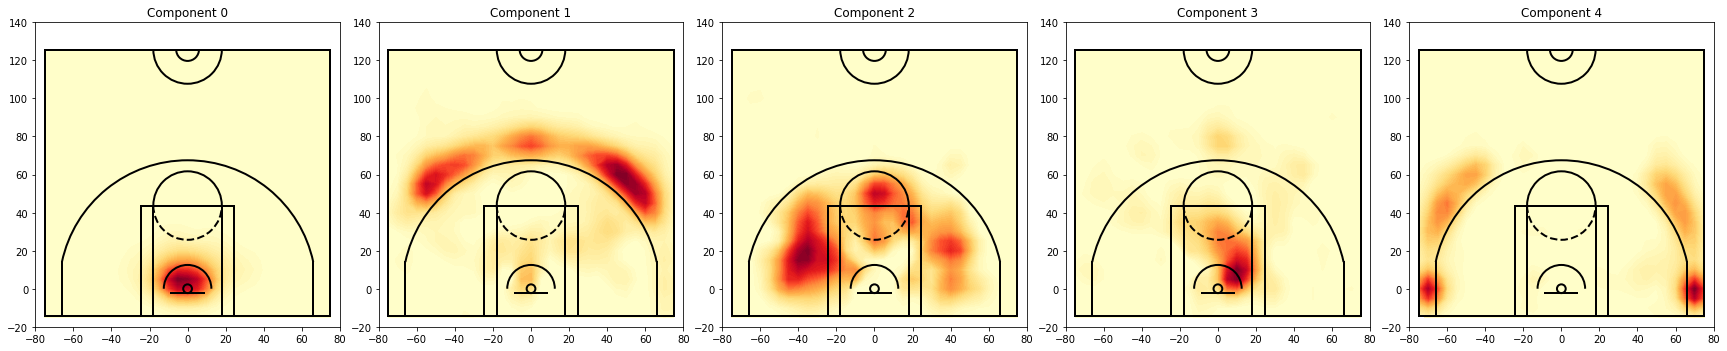

In [103]:
m,n = 1,5

#frobenius
#kullback-leibler

beta_loss='kullback-leibler'
# beta_loss='frobenius'
solver='mu'
init='nndsvda'

mod_name = 'img/{}_{}_{}_{}'.format(beta_loss, solver, init, m*n)

model = NMF(n_components=m*n, max_iter=2000, beta_loss=beta_loss, solver=solver, init=init)
# model = NMF(n_components=m*n, max_iter=2000, beta_loss='frobenius', solver='mu', init='nndsvdar')
# model = NMF(n_components=m*n, max_iter=2000, beta_loss='itakura-saito', solver='mu', init='nndsvda')
# model = NMF(n_components=m*n, max_iter=2000, beta_loss='frobenius', solver='cd')
samples = []

xgrid, ygrid = generate_xy_grids((-75,76,5), (-15,126,5))
xy = np.vstack([xgrid.ravel(), ygrid.ravel()]).T

for i in range(players.shape[0]):
    shooter = fg_df[(fg_df.player==players[i]) & (fg_df.made<=1)]
    if shooter.shape[0] > 14:
        locs =  get_locations(shooter)
        z = get_kde_court(locs, xy, bandwidth=5, kernel='gaussian')
        samples.append(z)
    else:
        pass

shots = np.vstack(samples)
nmf_features = model.fit_transform(shots)

# si = shots[i,:]
# ni = nmf_features[i,:]
# print(si)
# print(ni)
# np.matmul(ni, si)
f1, axs1 = plt.subplots(m,n,figsize=(24,22))
f1.set_tight_layout(True)

for i in range(model.components_.shape[0]):
    z = model.components_[i].reshape(xgrid.shape)
    levels = np.linspace(0, z.max(), 50)
    plt.subplot(m,n,i+1)
    plt.contourf(xgrid, ygrid, z, levels=levels, cmap=plt.cm.YlOrRd)
    draw_court(outer_lines=True)

    plt.xlim(-80,80)
    plt.ylim(-20, 140)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().set_title('Component {}'.format(i))
    
# plt.savefig(mod_name)

In [121]:
players

Index(['A. Pasaol', 'A. Melecio', 'R. Subido', 'D. Ildefonso', 'J. Ahanmisi',
       'Ju. Gomez de Liaño', 'B. Akhuetie', 'P. Desiderio', 'M. Lee',
       'S. Manganti', 'J. Clemente', 'J. Baltazar', 'P. Sarr', 'L. Santillian',
       'T. Ravena', 'P. Manalang', 'A. Kouame', 'A. Caracut', 'H. Cani',
       'W. Comboy', 'A. Tolentino', 'C. Cansino', 'J. Varilla', 'Z. Huang',
       'R. Verano', 'J. Manzo', 'Ja. Gomez de Liaño', 'J. Parker', 'R. Escoto',
       'S. Ildefonso', 'F. Serrano', 'A. Asistio', 'T. Rike', 'C. Conner',
       'J. Lastimosa', 'J. Espeleta', 'I. Gaye', 'K. Zamora', 'S. Camacho',
       'I. Go', 'M. Nieto', 'W. Bartolome', 'T. Tio', 'W. Navarro',
       'J. Gallego', 'K. Montalbo', 'A. Inigo', 'K. Tuffin', 'G. Mahinay',
       'J. Mendoza', 'D. Yu', 'B. Bienes', 'A. Joson', 'B. Ebona', 'P. Orizu',
       'S. Belangel', 'J. Pingoy', 'M. Dyke', 'A. Stockton', 'J. Marcos',
       'A. Wong', 'J. Manuel', 'E. Caunan', 'J. Cullar', 'C. Catapusan',
       'A. Diputado', '

(82, 5) (5, 899)


Text(0.5, 1.0, 'Player 0')

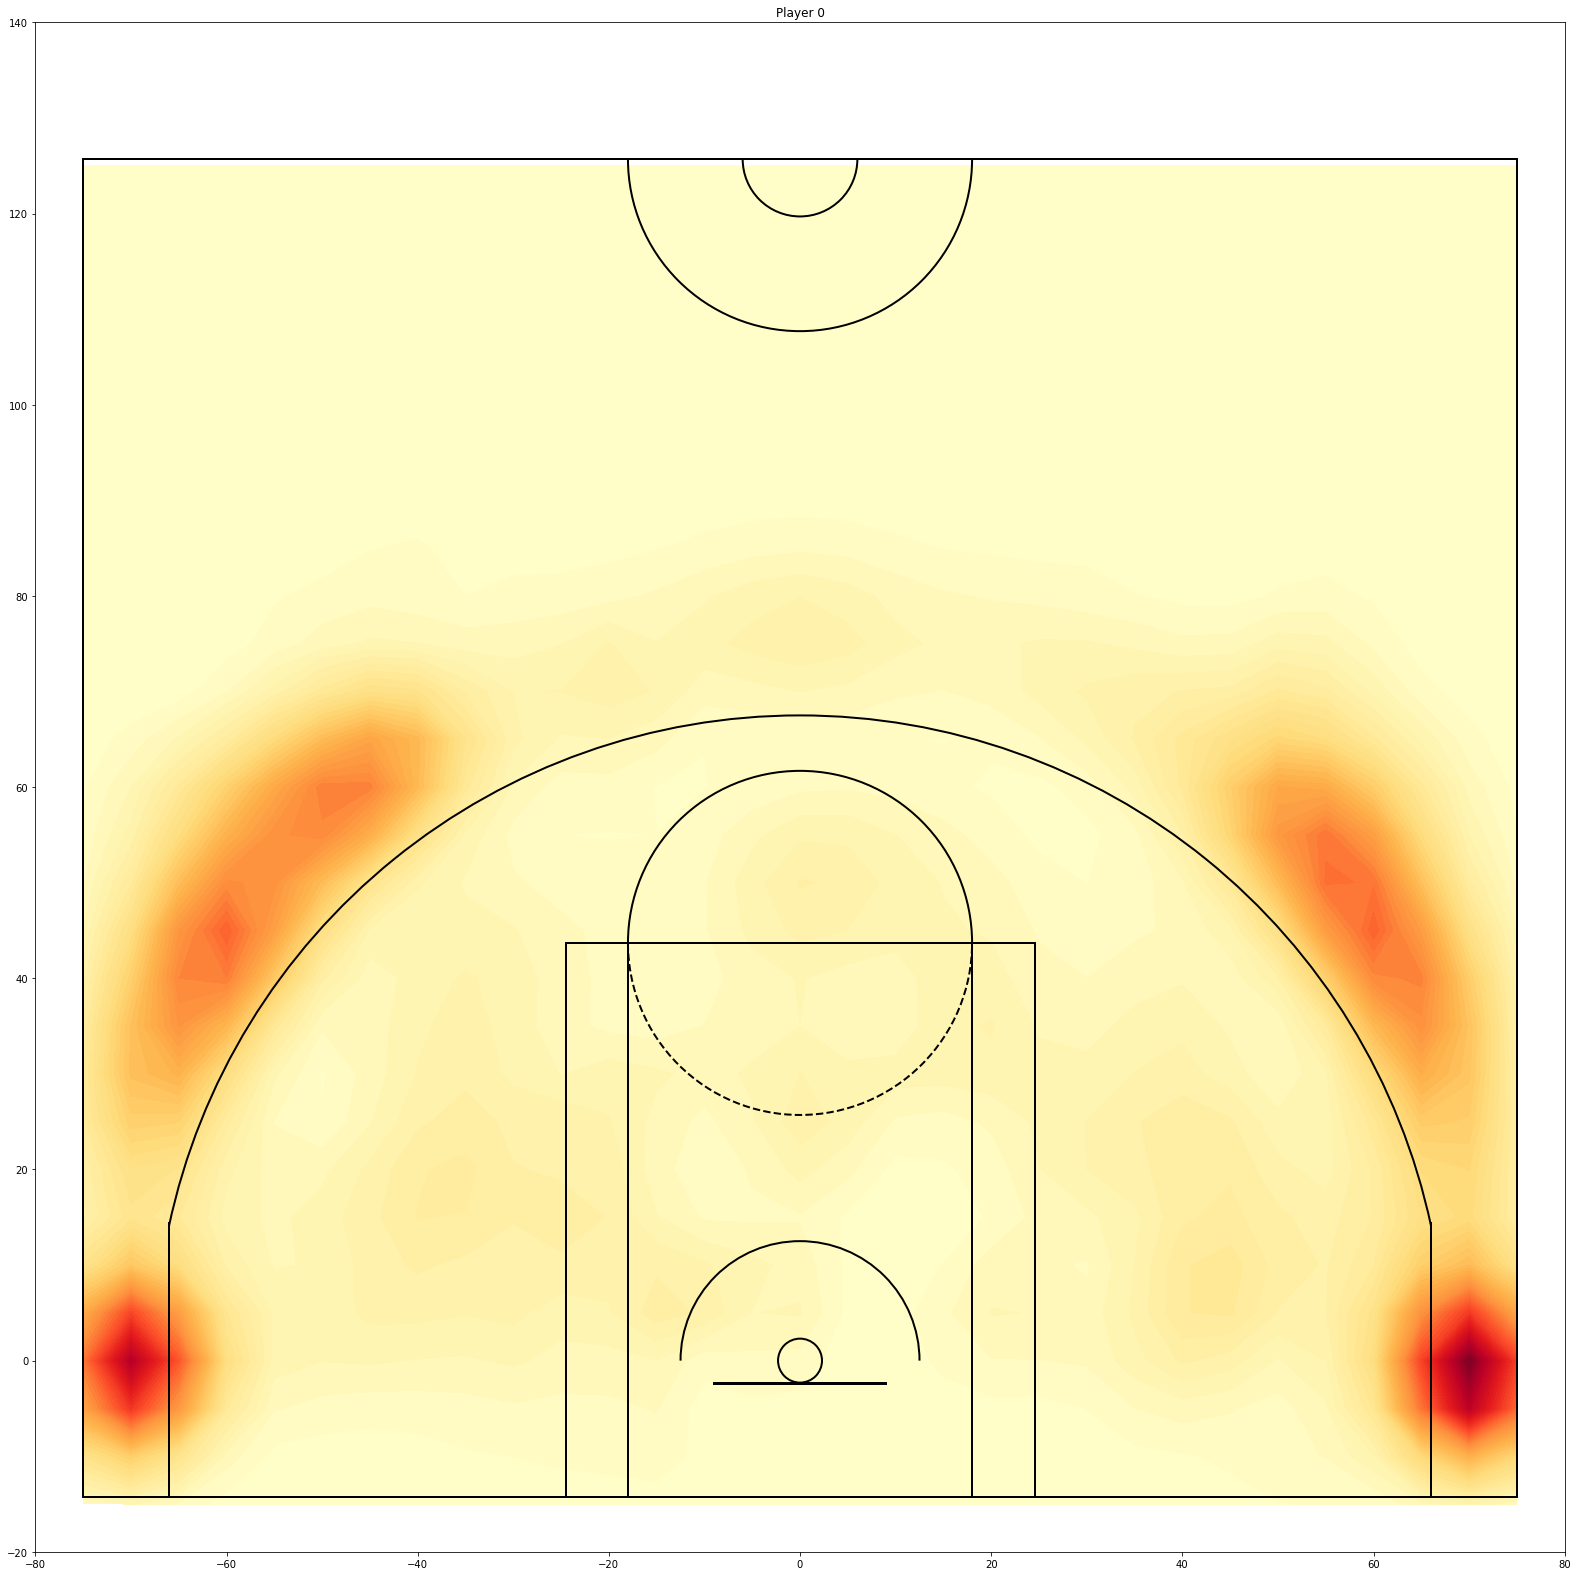

In [137]:
m,n = 1,1

#frobenius
#kullback-leibler

beta_loss='kullback-leibler'
# beta_loss='frobenius'
solver='mu'
init='nndsvda'

mod_name = 'img/{}_{}_{}_{}'.format(beta_loss, solver, init, m*n)

model = NMF(n_components=5, max_iter=2000, beta_loss=beta_loss, solver=solver, init=init)
# model = NMF(n_components=m*n, max_iter=1000, beta_loss='frobenius', solver='mu', init='nndsvdar')
# model = NMF(n_components=m*n, max_iter=1000, beta_loss='itakura-saito', solver='mu', init='nndsvda')
# model = NMF(n_components=m*n, max_iter=10000, beta_loss='frobenius', solver='cd')
samples = []

xgrid, ygrid = generate_xy_grids((-75,76,5), (-15,126,5))
xy = np.vstack([xgrid.ravel(), ygrid.ravel()]).T

for i in range(players.shape[0]):
    shooter = fg_df[(fg_df.player==players[i]) & (fg_df.made<=1)]
    if shooter.shape[0] > 14:
        locs =  get_locations(shooter)
        z = get_kde_court(locs, xy, bandwidth=5, kernel='gaussian')
        samples.append(z)
    else:
        pass

shots = np.vstack(samples)

nmf_W = model.fit_transform(shots)
nmf_H = model.components_

np.savetxt('nmf_H.csv', nmf_H, delimiter=',')
np.savetxt('nmf_W.csv', nmf_W, delimiter=',')

print(nmf_W.shape, nmf_H.shape)
p_basis = np.matmul(nmf_W, nmf_H)

# p_basis[0].shape

f1, axs1 = plt.subplots(m,n,figsize=(24,22))
f1.set_tight_layout(True)

p_z = p_basis[50].reshape(xgrid.shape)
levels = np.linspace(0, p_z.max(), 50)
# plt.subplot(m,n,i+1)
plt.contourf(xgrid, ygrid, p_z, levels=levels, cmap=plt.cm.YlOrRd)
draw_court(outer_lines=True)

plt.xlim(-80,80)
plt.ylim(-20, 140)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().set_title('Player 0')


# si = shots[i,:]
# ni = nmf_features[i,:]
# print(si)
# print(ni)
# np.matmul(ni, si)
# f1, axs1 = plt.subplots(m,n,figsize=(24,22))
# f1.set_tight_layout(True)

# for i in range(model.components_.shape[0]):
#     z = model.components_[i].reshape(xgrid.shape)
#     levels = np.linspace(0, z.max(), 50)
#     plt.subplot(m,n,i+1)
#     plt.contourf(xgrid, ygrid, z, levels=levels, cmap=plt.cm.YlOrRd)
#     draw_court(outer_lines=True)

#     plt.xlim(-80,80)
#     plt.ylim(-20, 140)
#     plt.gca().set_aspect('equal', adjustable='box')
#     plt.gca().set_title('Component {}'.format(i))
    
# plt.savefig(mod_name)